In [508]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.dates as mdates # type: ignore
import matplotlib.ticker as ticker # type: ignore
from matplotlib.axis import Axis # type: ignore
import datetime as dt 

import time
start = time.time()

In [509]:
def get_data2(filename):    
    data = pd.read_csv(filename) #, names=["Interval","kWh"])
    return data
    
def conso_byhour(day):
    ''' 
    display conso by hour for the chosen day
    '''
    conso_day=conso_data[conso_data['days']==day].copy()  # type: ignore # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))

    conso_hours = conso_day.copy()
    conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
    conso_hours#.info()
    # group by hour
    groupedbyhour = conso_hours[['hours','kWh']].groupby('hours', sort=False)
    groupedbyhour.count()
    len(groupedbyhour)
    x = np.arange(1,len(groupedbyhour)+1)

    #groupedbyhour.count().plot(grid=True,xticks=x)
    plt.figure(figsize=(12, 8),facecolor='darkcyan')
    values = groupedbyhour.count().kWh
    #ax = plt.bar(x,groupedbyhour.count().kWh)
    ax = values.plot(kind="bar",color='green',width=.8)
    ax.set_facecolor('antiquewhite')
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) - {day}')
    plt.xlim(-1,len(x)+1)
    plt.xticks(rotation=30);
    
    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in values]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom",
            fontfamily='calibri', fontsize=16, fontweight='bold', color='blue'
        )
    
    
def from_csv(csv_file): 
    ''' save data to csv  '''
    df = pd.read_csv(csv_file)
    return df
    
def to_csv(csv_file, df):
    ''' read data from csv'''
    df.to_csv(csv_file, index=False)


### conso.csv créé par pi4 node-red onglet Linky
#### création de conso_data 

In [510]:
conso_file = r"\\192.168.0.175\pihome\Documents\conso2.csv"
conso_data = get_data2(conso_file)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2391321 entries, 0 to 2391320
Data columns (total 2 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Interval  int64  
 1   kWh       float64
dtypes: float64(1), int64(1)
memory usage: 36.5 MB


# reduce to 1 million events

In [511]:
conso_data = conso_data.tail(1000000)
conso_data.reset_index(drop=True, inplace=True)
conso_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Interval  1000000 non-null  int64  
 1   kWh       1000000 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 15.3 MB


### conversion millisec -> sec

In [512]:
conso_data['sec']=conso_data['Interval']/1000
conso_data

,Interval,kWh,sec
0,19027,0.19,19.027
1,19214,0.19,19.214
2,19195,0.19,19.195
3,19302,0.19,19.302
4,19385,0.19,19.385
...,...,...,...
999995,29757,0.12,29.757
999996,30012,0.12,30.012
999997,29884,0.12,29.884
999998,29953,0.12,29.953


### conversion Interval -> kWh

In [513]:
conso_data['Wh']=3600000/conso_data['Interval']
conso_data


,Interval,kWh,sec,Wh
0,19027,0.19,19.027,189.204814
1,19214,0.19,19.214,187.363381
2,19195,0.19,19.195,187.548841
3,19302,0.19,19.302,186.509170
4,19385,0.19,19.385,185.710601
...,...,...,...,...
999995,29757,0.12,29.757,120.979937
999996,30012,0.12,30.012,119.952019
999997,29884,0.12,29.884,120.465801
999998,29953,0.12,29.953,120.188295


### Cumul Total interval

In [514]:
conso_data['cumul(ms)']=conso_data['Interval'].cumsum(axis=0)

In [515]:
l=len(conso_data)-1
cumtime= int(conso_data._get_value(l,'cumul(ms)')*1000)  # convert to microseconds
cumtime

27100133984000

### Calcul de la date de base = now - cumul_interval

In [516]:
from datetime import datetime, timedelta
now = datetime.now()
# conso.csv dynamique
base = now - timedelta(microseconds=cumtime)
base  # date de début

datetime.datetime(2024, 9, 3, 21, 1, 26, 408927)

In [517]:
conso_data['cumul(ms)'][conso_data['cumul(ms)'].isna()==True]

Series([], Name: cumul(ms), dtype: int64)

In [518]:
conso_data.iloc[0]


Interval     19027.000000
kWh              0.190000
sec             19.027000
Wh             189.204814
cumul(ms)    19027.000000
Name: 0, dtype: float64

### Recréer les dates à partir des cumuls par impulsion


In [519]:
base

datetime.datetime(2024, 9, 3, 21, 1, 26, 408927)

## créer les dates

In [520]:
# create column 'dates' with time cumulated time from base
conso_data['dates'] = [base + dt.timedelta(microseconds=t*1000) for t in conso_data['cumul(ms)']]
conso_data['dates']

0        2024-09-03 21:01:45.435927
1        2024-09-03 21:02:04.649927
2        2024-09-03 21:02:23.844927
3        2024-09-03 21:02:43.146927
4        2024-09-03 21:03:02.531927
                    ...            
999995   2025-07-14 12:48:21.892927
999996   2025-07-14 12:48:51.904927
999997   2025-07-14 12:49:21.788927
999998   2025-07-14 12:49:51.741927
999999   2025-07-14 12:50:20.392927
Name: dates, Length: 1000000, dtype: datetime64[ns]

### create column 'days' avec format 'dd/mm/yy'


In [521]:
conso_data['days']= [d.strftime('%d/%m/%y') for d in conso_data['dates']]    
#[str(d.month)+'-'+str(d.day) for d in conso_data['dates']]
conso_data

,Interval,kWh,sec,Wh,cumul(ms),dates,days
0,19027,0.19,19.027,189.204814,19027,2024-09-03 21:01:45.435927,03/09/24
1,19214,0.19,19.214,187.363381,38241,2024-09-03 21:02:04.649927,03/09/24
2,19195,0.19,19.195,187.548841,57436,2024-09-03 21:02:23.844927,03/09/24
3,19302,0.19,19.302,186.509170,76738,2024-09-03 21:02:43.146927,03/09/24
4,19385,0.19,19.385,185.710601,96123,2024-09-03 21:03:02.531927,03/09/24
...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25


### save conso_data with dates

In [522]:
#to_csv(r'../conso_data_with_dates.csv',conso_data)

# tranche journalière


In [523]:
now = datetime.now()
month = now.month
year = now.year
date = now.day
today = now.strftime('%d/%m/%y')    #str(now.month)+'-'+str(now.day)
here = now.strftime('%H:%M:%S')
today, date, month, year, here

('14/07/25', 14, 7, 2025, '12:50:37')

In [524]:
conso_day = conso_data[conso_data['days']==today]
# save to file
filename='conso_jour.csv'
conso_day.to_csv(filename)
filename='../conso_jour.csv'
conso_day.to_csv(filename)

In [525]:
conso_day.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 998350 to 999999
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1650 non-null   int64         
 1   kWh        1650 non-null   float64       
 2   sec        1650 non-null   float64       
 3   Wh         1650 non-null   float64       
 4   cumul(ms)  1650 non-null   int64         
 5   dates      1650 non-null   datetime64[ns]
 6   days       1650 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 103.1+ KB


In [526]:
end = time.time()
print(end - start)

23.670060873031616


### grouped by days

In [527]:
# group by day
grouped = conso_data[['days','kWh']].groupby('days', sort=False)
'''conso_graph=[]
for name, group in grouped:
    if name=='01/04/2024':print(group)
    #print("\n", name, len(group)/1000)
    conso_graph.append((name,len(group)/1000))'''
#grouped
# count elements in each group => conso in watts => convert to kW
df_grp = grouped.count()/1000



In [528]:
data = list(df_grp['kWh'])
print(data)

[0.374, 4.131, 3.528, 3.658, 3.603, 3.155, 2.616, 1.799, 1.792, 1.795, 1.794, 2.414, 1.924, 1.787, 1.793, 1.788, 1.819, 1.82, 1.818, 1.814, 1.818, 1.817, 1.815, 1.818, 1.785, 1.787, 1.784, 1.785, 1.783, 1.798, 1.788, 1.79, 1.785, 1.793, 1.801, 1.798, 1.799, 1.801, 1.785, 1.787, 1.788, 1.788, 1.798, 1.791, 1.799, 1.804, 1.793, 1.802, 1.798, 2.644, 3.999, 3.68, 3.897, 3.091, 3.356, 4.133, 3.358, 3.505, 3.989, 3.324, 3.732, 3.577, 3.973, 3.204, 3.316, 3.396, 4.094, 3.283, 3.39, 3.82, 3.226, 3.542, 3.293, 3.914, 3.351, 3.422, 3.753, 4.411, 3.604, 3.854, 3.372, 4.222, 3.497, 3.447, 3.284, 3.861, 3.686, 4.117, 3.212, 3.729, 3.808, 3.155, 3.685, 3.655, 3.384, 3.881, 3.189, 4.065, 3.448, 3.706, 4.07, 3.412, 4.53, 3.264, 3.466, 3.108, 3.219, 3.431, 3.351, 3.419, 3.429, 4.605, 4.545, 3.227, 3.454, 3.635, 3.933, 3.545, 4.457, 4.179, 4.088, 3.776, 3.736, 3.55, 3.537, 4.386, 3.165, 3.382, 3.399, 3.449, 3.611, 3.378, 4.556, 3.259, 3.786, 3.249, 3.603, 3.543, 3.288, 3.995, 3.276, 4.686, 3.928, 3.312,

In [529]:
# save to file
# import pickle
# path = r'kwh_mean.pkl'
# with open(path,'wb') as file:
#     pickle.dump(data, file)

In [530]:
end = time.time()
print(end - start)

24.68920135498047


### plot function by day
#### show('dd/mm/yy')

In [531]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # type: ignore
def show(day,pltcolor='darkcyan',bgcolor="ivory"):
    conso_day=conso_data[conso_data['days']==day].copy()  # no more error
    conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)+':'+str(x.minute) +':'+str(x.second))
    #=[x.hour for x in conso_day['dates']]
    #print(conso_day)
    df = conso_day.set_index('heure')
    here = now.strftime('%H:%M:%S')
    conso_jour=len(df['kWh'])
    here, len(df)/1000, conso_jour

    # consommation d'une journée entière à partir de minuit
    # Set background color of the outer 
    # area of the plt
    #plt.figure(facecolor=fgcolor)
    fig, ax = plt.subplots(facecolor=pltcolor)
    
    major_ticks=300;minor_ticks=100
    ax.xaxis.set_major_locator(MultipleLocator(major_ticks))  # major ticks tous les 15 min
    ax.xaxis.set_minor_locator(MultipleLocator(minor_ticks))
    # the size of A4 paper
    fig.set_size_inches(10, 5)
    
    # set bg color
    ax.set_facecolor(bgcolor)
    plt.plot(df['kWh'])
    #plt.plot(conso_day['heure'],conso_day['kWh'])
    plt.title(f'Journée du {day} {here} : {conso_jour/1000} kwh')
    plt.grid()
    plt.xticks(rotation=30);


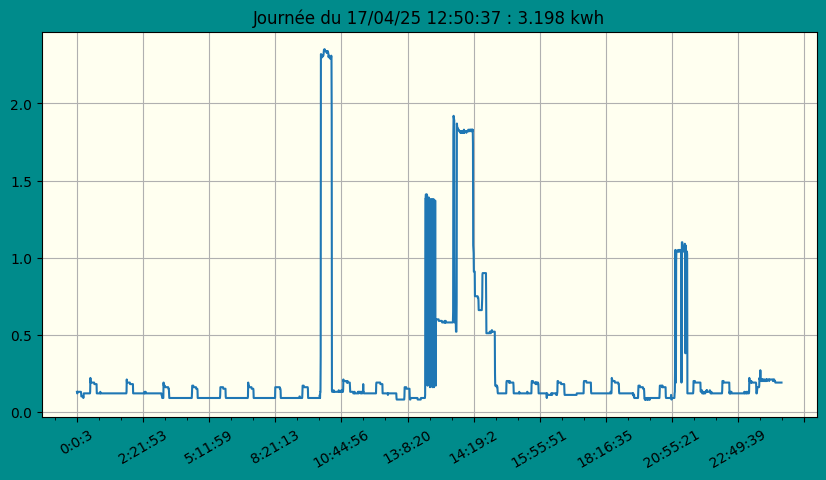

In [532]:
show('17/04/25')

In [533]:
end = time.time()
print(end - start)

26.799890756607056


### 1 kWh window in data of one day
#### df = conso_day

In [534]:
df = conso_day
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998350,35533,0.10,35.533,101.314271,27053940694,2025-07-14 00:00:27.102927,14/07/25
998351,34306,0.10,34.306,104.937912,27053975000,2025-07-14 00:01:01.408927,14/07/25
998352,33179,0.11,33.179,108.502366,27054008179,2025-07-14 00:01:34.587927,14/07/25
998353,33403,0.11,33.403,107.774751,27054041582,2025-07-14 00:02:07.990927,14/07/25
998354,33830,0.11,33.830,106.414425,27054075412,2025-07-14 00:02:41.820927,14/07/25
...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25


In [535]:

def period(df=df, p=1):
    ''' 
    give the time of conso for a 1kWh window in a day
    p =  ordinal window ex: p=1 first kWh, p=2 second kWh ..
    df is the data from midnight, each entry is 1 watt
    as the length of df is the total conso in watt,
    we have len(df)/1000 = number of windows of 1 KWh since midnight
    the last window may not be 1000 watt long !
    '''
    if p==1:
        start = df.iloc[0].dates
    else:
        start = df.iloc[(p-1)*1000-1].dates
    if len(df)>p*1000:
        end = df.iloc[p*1000-1].dates
        conso = p*1000
    else:
        end = df.iloc[len(df)-1].dates
        conso = len(df) - (p-1)*1000
    period = end - start  # type timedelta
    hours = int(period / dt.timedelta(hours=1))
    mins = int(period / dt.timedelta(minutes=1)) - hours*60
    secs = int(period / dt.timedelta(seconds=1)) - hours*3600 - mins*60

    #df.iloc[1001:2000]['dates']#.tail(1)
    #print(period)
    print(f'{start}\t{end}\t{hours}h {mins}m {secs}s \t{conso}')


In [536]:
df = conso_day
len(df)

1650

In [537]:
period()  # first kWh
if len(df)>1000:
    period(p=2) # second period

2025-07-14 00:00:27.102927	2025-07-14 08:14:24.810927	8h 13m 57s 	1000
2025-07-14 08:14:24.810927	2025-07-14 12:50:20.392927	4h 35m 55s 	650


In [538]:
# mean of all instant conso
total_mean = conso_data[['kWh']].mean()
total_mean

kWh    0.300425
dtype: float64

In [539]:
end = time.time()
print(end - start)

27.814255714416504


## mean for data grouped by days

In [540]:
mean=(grouped.count()/1000).mean()
mean

kWh    3.174603
dtype: float64

In [541]:
last=df_grp.iloc[-1]['kWh']
last

np.float64(1.65)

# conso by date


In [542]:
# select day
day = today

#day = '16/08/24'
day

'14/07/25'

In [543]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998350,35533,0.10,35.533,101.314271,27053940694,2025-07-14 00:00:27.102927,14/07/25
998351,34306,0.10,34.306,104.937912,27053975000,2025-07-14 00:01:01.408927,14/07/25
998352,33179,0.11,33.179,108.502366,27054008179,2025-07-14 00:01:34.587927,14/07/25
998353,33403,0.11,33.403,107.774751,27054041582,2025-07-14 00:02:07.990927,14/07/25
998354,33830,0.11,33.830,106.414425,27054075412,2025-07-14 00:02:41.820927,14/07/25
...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25


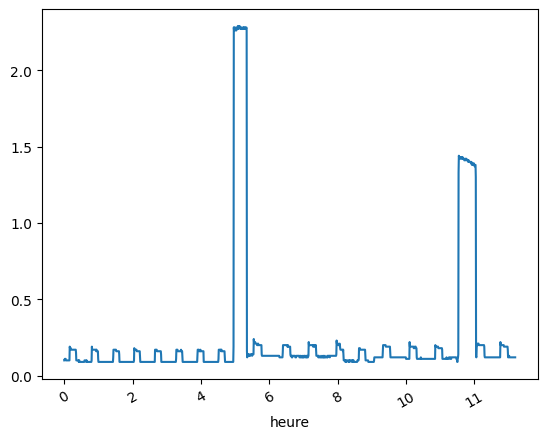

In [544]:
conso_day=conso_data[conso_data['days']==day].copy()  # no more error
conso_day['heure']=conso_day['dates'].apply(lambda x: str(x.hour)) #+':'+str(x.minute) +':'+str(x.second))
#=[x.hour for x in conso_day['dates']]
df3= conso_day.set_index('heure')
df3.tail(2000)['kWh'].plot()
plt.xticks(rotation=30);
#conso_day['heure']


In [545]:
end = time.time()
print(end - start)

29.319119930267334


### grouped by 'heure'

In [546]:
conso_day.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 998350 to 999999
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1650 non-null   int64         
 1   kWh        1650 non-null   float64       
 2   sec        1650 non-null   float64       
 3   Wh         1650 non-null   float64       
 4   cumul(ms)  1650 non-null   int64         
 5   dates      1650 non-null   datetime64[ns]
 6   days       1650 non-null   object        
 7   heure      1650 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(2)
memory usage: 116.0+ KB


In [547]:
df

,Interval,kWh,sec,Wh,cumul(ms),dates,days
998350,35533,0.10,35.533,101.314271,27053940694,2025-07-14 00:00:27.102927,14/07/25
998351,34306,0.10,34.306,104.937912,27053975000,2025-07-14 00:01:01.408927,14/07/25
998352,33179,0.11,33.179,108.502366,27054008179,2025-07-14 00:01:34.587927,14/07/25
998353,33403,0.11,33.403,107.774751,27054041582,2025-07-14 00:02:07.990927,14/07/25
998354,33830,0.11,33.830,106.414425,27054075412,2025-07-14 00:02:41.820927,14/07/25
...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25


In [548]:
# group by hour, df  = data of a chosen day
df_byhour = df3[['days','kWh']].groupby('heure', sort=False)
df_byhour.groups

{'0': ['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', ...], '1': ['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '

In [549]:
kwh_byhour = df_byhour['kWh']
kwh_byhour.count()

heure
0     113
1     106
2      99
3     108
4     102
5     152
6     150
7     137
8     120
9     127
10    126
11    197
12    113
Name: kWh, dtype: int64

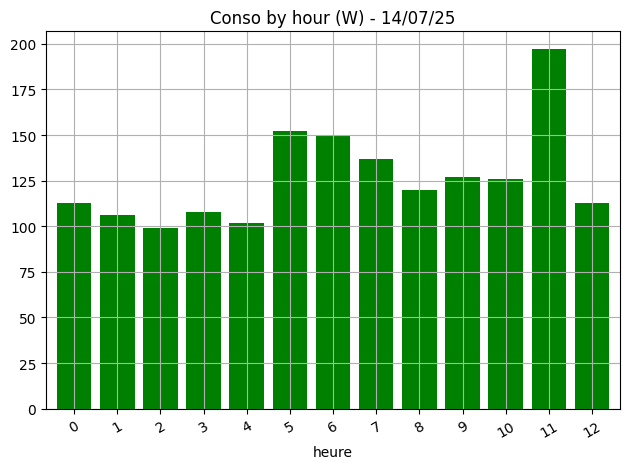

In [550]:
kwh_byhour.count().plot(grid=True, kind='bar',color='green',width=.8)
plt.title(f'Conso by hour (W) - {day}')
plt.xticks(rotation=30);
plt.tight_layout()

In [551]:
df_grp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 03/09/24 to 14/07/25
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     315 non-null    float64
dtypes: float64(1)
memory usage: 4.9+ KB


In [552]:
# give the periods of 1 kwh in a day
period()

2025-07-14 00:00:27.102927	2025-07-14 08:14:24.810927	8h 13m 57s 	1000


In [553]:

# premier kWh
if len(df)>1000:
    df.iloc[1000]['dates']
    df.iloc[0].dates, df.iloc[1000].dates
#df.dates.dt.time


In [554]:

# save data
# df_grp.to_csv('df_grp.csv')
# df.to_csv('df.csv')
df_grp.to_csv('conso_day_from_20230821.csv')

#df.info()
#df_grp


In [555]:
df_grp.mean()


kWh    3.174603
dtype: float64

In [556]:
df_grp.head()


,kWh
days,
03/09/24,0.374
04/09/24,4.131
05/09/24,3.528
06/09/24,3.658
07/09/24,3.603


In [557]:
df_grp.tail()


,kWh
days,
10/07/25,2.937
11/07/25,2.679
12/07/25,2.600
13/07/25,2.712
14/07/25,1.650


In [558]:
end = time.time()
print(end - start)

30.918449878692627


# plot les 100 derniers jours


In [559]:
# moyenne sur 100 jours
df_grp.tail(100).mean()


kWh    2.98918
dtype: float64

Text(0.5, 1.0, 'Conso (kWh) last 100 days')

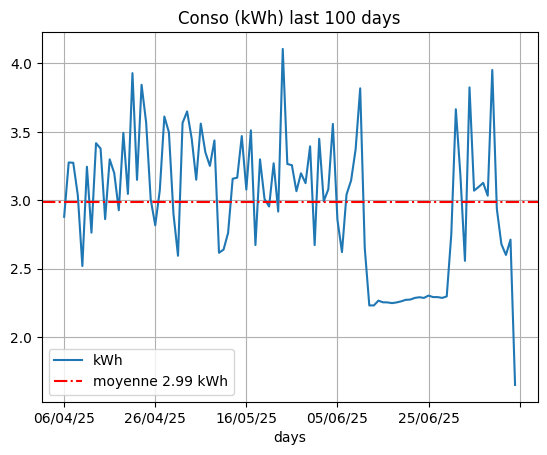

In [560]:
# plot last 100 days
df_100 = df_grp.tail(100)
df_100.plot()
plt.axhline(y=np.nanmean(df_100),c='red', ls='-.',label=f'moyenne {np.nanmean(df_100):.2f} kWh')
plt.grid()
plt.legend()
plt.title('Conso (kWh) last 100 days')


In [561]:
# max min during last 100 days
df_100.describe().loc[['min','max']]


,kWh
min,1.650
max,4.106


In [562]:
end = time.time()
print(end - start)

32.11327648162842


In [563]:
df_grp[-31:-1].index[0],df_grp[-31:-1].index[-5]

('14/06/25', '09/07/25')

In [564]:
moyenne = df_grp.iloc[-31:-1].mean()
moyenne

kWh    2.653367
dtype: float64

Text(0.5, 1.0, 'Last month conso by day')

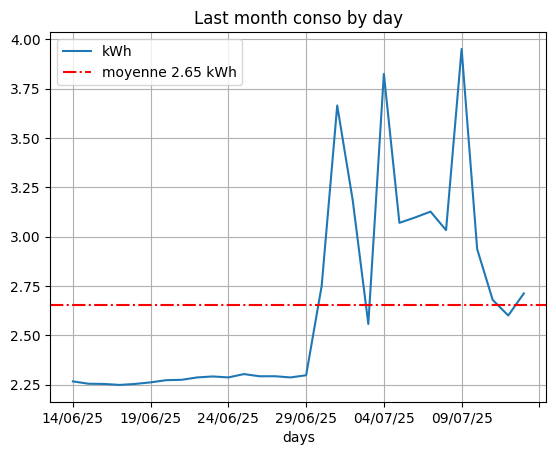

In [565]:
# plot last monthh
df_grp.iloc[-31:-1].plot()
plt.axhline(y=np.nanmean(df_grp.iloc[-31:-1]),c='red', ls='-.',label=f'moyenne {np.nanmean(df_grp.iloc[-31:-1]):.2f} kWh')  
plt.legend()
plt.grid()
plt.title('Last month conso by day')


In [566]:
month = df_grp.iloc[-31:-1]['kWh']
print('Max :',month.idxmax(), max(month))
print('Min :',month.idxmin(), min(month))

Max : 09/07/25 3.952
Min : 17/06/25 2.248


# Temps de conso par tranche de 1 kWh

In [567]:
def show_tranches():    # temps de conso par tranches de 1kwh
    tranches = len(df)//1000
    print(tranches+1)
    for p in range(1,tranches+2):  # les 5 tranches de kWh consommés
        if len(df)>(p-1)*1000:
            period(p=p)

show_tranches()


2
2025-07-14 00:00:27.102927	2025-07-14 08:14:24.810927	8h 13m 57s 	1000
2025-07-14 08:14:24.810927	2025-07-14 12:50:20.392927	4h 35m 55s 	650


In [568]:
# conso temps réel
here = now.strftime('%H:%M:%S')
conso_jour=len(df['kWh'])
here, len(df)/1000, conso_jour


('12:50:37', 1.65, 1650)

In [569]:
#add hours column for a chosen day
conso_hours = conso_day.copy()
conso_hours['hours']= conso_hours['dates'].dt.strftime('%H')
conso_hours.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1650 entries, 998350 to 999999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Interval   1650 non-null   int64         
 1   kWh        1650 non-null   float64       
 2   sec        1650 non-null   float64       
 3   Wh         1650 non-null   float64       
 4   cumul(ms)  1650 non-null   int64         
 5   dates      1650 non-null   datetime64[ns]
 6   days       1650 non-null   object        
 7   heure      1650 non-null   object        
 8   hours      1650 non-null   object        
dtypes: datetime64[ns](1), float64(3), int64(2), object(3)
memory usage: 128.9+ KB


In [570]:
conso_hours['heure'], conso_hours['hours']

(998350     0
 998351     0
 998352     0
 998353     0
 998354     0
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: heure, Length: 1650, dtype: object,
 998350    00
 998351    00
 998352    00
 998353    00
 998354    00
           ..
 999995    12
 999996    12
 999997    12
 999998    12
 999999    12
 Name: hours, Length: 1650, dtype: object)

In [571]:
end = time.time()
print(end - start)

33.29670000076294


# select number of days to display


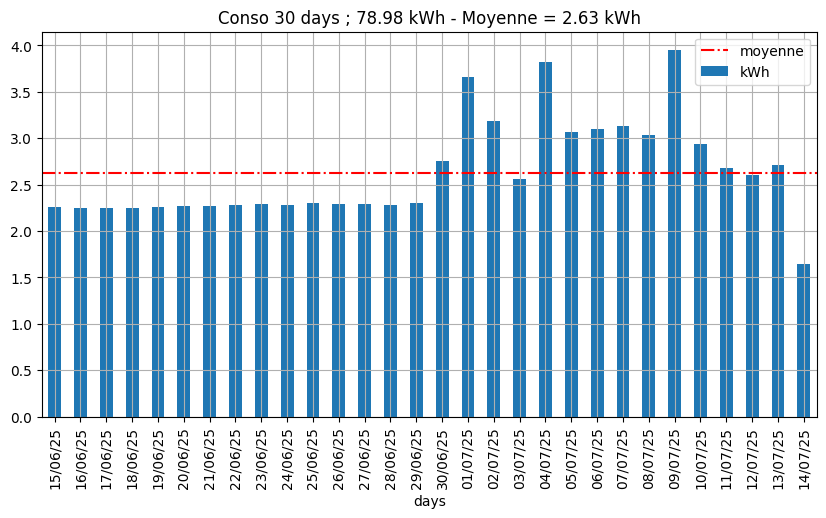

In [572]:
span = 30
conso_mois = round(df_grp.tail(span)['kWh'].sum(),2)

# Plot the figure without labels
moy = round(np.nanmean(df_grp.tail(span)),2)
#conso_mois = sum(df_grp.tail(span)['kWh'])
df_grp.tail(span).plot.bar(grid=True, figsize=(10, 5), layout='tight')
 
plt.title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
plt.xticks(rotation=90);


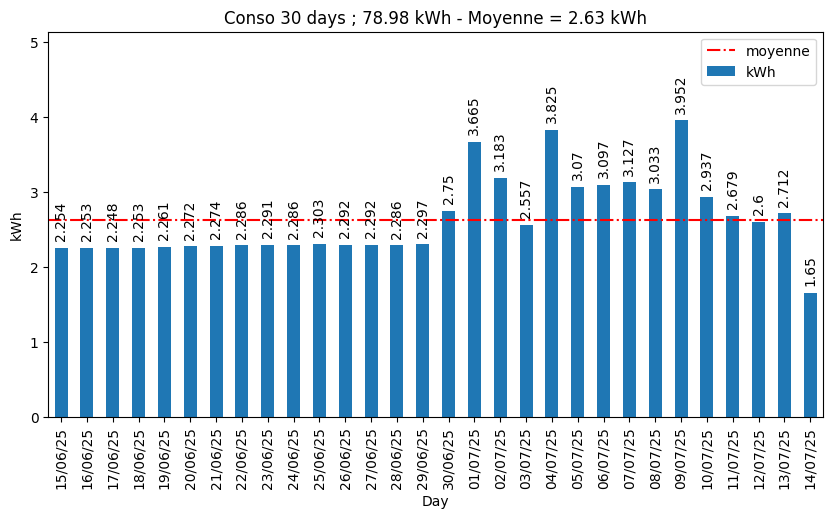

In [573]:
# Plot the figure with labels.
x_labels = list(df_grp.tail(span)['kWh'])
#x_labels
#fig, ax = plt.subplots(figsize=(2, 2), facecolor='lightskyblue',layout='constrained')
ax = df_grp.tail(span).plot(kind="bar", figsize=(10, 5), layout='tight')
#ax.set_title(f"Conso by {span} days")
ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.set_xlabel("Day")
ax.set_ylabel("kWh")
ax.set_ymargin(0.3)
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
#ax.set_xticklabels(x_labels)
#fig.tight_layout()

rects = ax.patches

# Make some labels.
labels = [x_labels[i] for i in range(len(x_labels))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    #print(height)
    ax.text(
        rect.get_x() + rect.get_width() / 2, height+.1, label, ha="center", va="bottom", rotation=90
    )

#plt.show()

In [574]:
y_labels = df_grp.tail(span)['kWh']
y_labels

days
15/06/25    2.254
16/06/25    2.253
17/06/25    2.248
18/06/25    2.253
19/06/25    2.261
20/06/25    2.272
21/06/25    2.274
22/06/25    2.286
23/06/25    2.291
24/06/25    2.286
25/06/25    2.303
26/06/25    2.292
27/06/25    2.292
28/06/25    2.286
29/06/25    2.297
30/06/25    2.750
01/07/25    3.665
02/07/25    3.183
03/07/25    2.557
04/07/25    3.825
05/07/25    3.070
06/07/25    3.097
07/07/25    3.127
08/07/25    3.033
09/07/25    3.952
10/07/25    2.937
11/07/25    2.679
12/07/25    2.600
13/07/25    2.712
14/07/25    1.650
Name: kWh, dtype: float64

In [575]:
x_labels=df_grp.tail(span).index
x_labels

Index(['15/06/25', '16/06/25', '17/06/25', '18/06/25', '19/06/25', '20/06/25',
       '21/06/25', '22/06/25', '23/06/25', '24/06/25', '25/06/25', '26/06/25',
       '27/06/25', '28/06/25', '29/06/25', '30/06/25', '01/07/25', '02/07/25',
       '03/07/25', '04/07/25', '05/07/25', '06/07/25', '07/07/25', '08/07/25',
       '09/07/25', '10/07/25', '11/07/25', '12/07/25', '13/07/25', '14/07/25'],
      dtype='object', name='days')

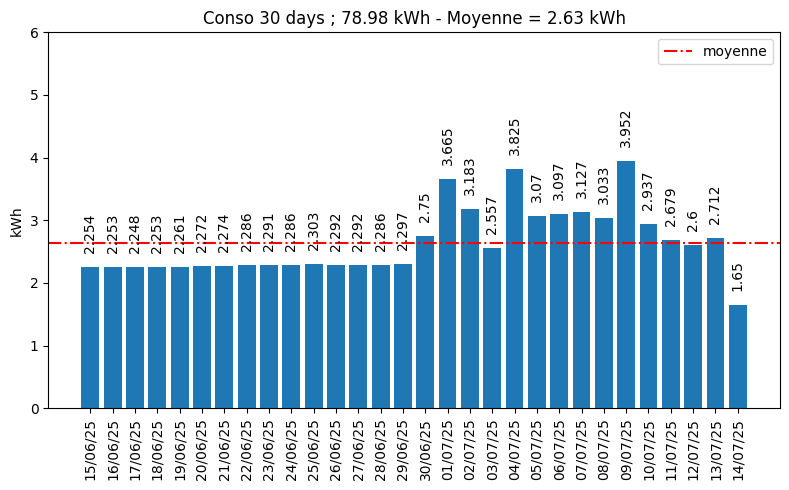

In [576]:
# Plot the figure with labels
# using bar_label
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html#sphx-glr-gallery-lines-bars-and-markers-bar-label-demo-py
fig, ax = plt.subplots(figsize=(8, 5), layout='tight')
bar_container = ax.bar(x_labels, y_labels)
#ax.set_xticks(x_labels, rotation=45)
#ax.set_title(f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh')
ax.bar_label(bar_container, rotation=90, padding=10) #, fmt='{:,.0f}')
plt.axhline(y=moy,c='red', ls='-.',label='moyenne')
plt.legend()
ax.set(ylabel='kWh', title=f'Conso {span} days ; {conso_mois} kWh - Moyenne = {moy} kWh', ylim=(0, 6))
plt.xticks(rotation=90);


In [577]:
end = time.time()
print(end - start)

39.43181300163269


In [578]:
# figure manager

current=plt.get_current_fig_manager()
current.set_window_title('Conso by day')
#help(current.canvas)
#,facecolor='darkcyan')
#plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
#plt.style.use('dark_background')


<Figure size 640x480 with 0 Axes>

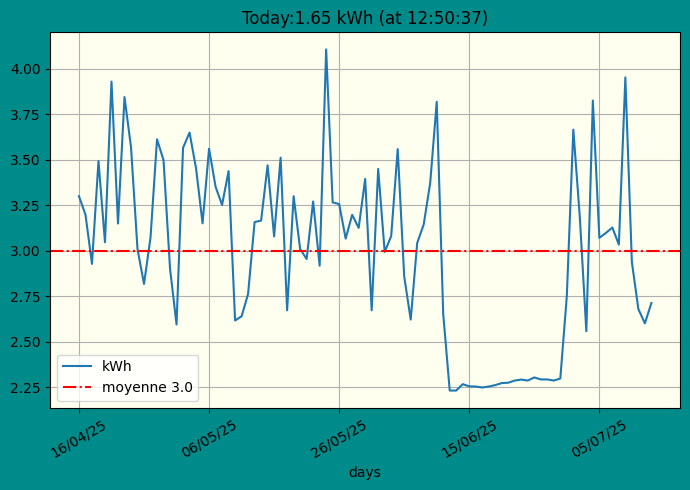

In [579]:
# 3 last months
scan = 90
# pandas plot the day consos in the group
fig, ax = plt.subplots(facecolor='darkcyan', figsize=(7, 5), layout='tight')  # as argument
#or fig.patch.set_facecolor('darkcyan') # This changes the grey to white
ax.set_facecolor("ivory")

moy = round(np.nanmean(df_grp.iloc[-scan:-1]),2)
df_grp.iloc[-scan:-1].plot(grid=True,ax=ax, y=["kWh"])   #df.plot(x="Name", y=["Age", "Height(in cm)"], kind="bar", ax=ax)
plt.title(f'Today:{last} kWh (at {here})')
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.xticks(rotation=30);  # https://ipython.readthedocs.io/en/stable/interactive/tips.html


Text(0.5, 1.0, 'Variations journalières')

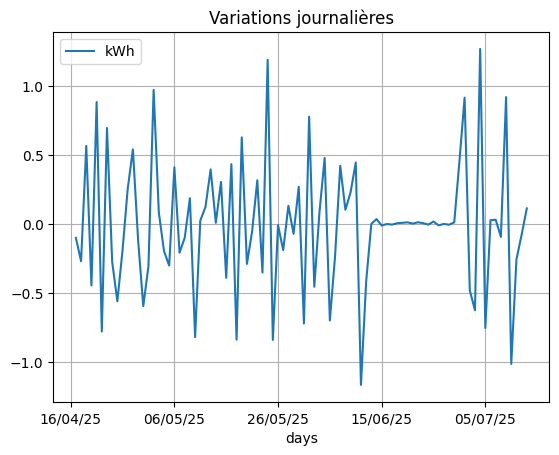

In [580]:
# variations journalières sur 60 jours
df_grp.iloc[-scan:-1].diff().plot(grid=True)
plt.title('Variations journalières')

In [581]:
end = time.time()
print(end - start)

40.44952392578125


# Data from 21/08/23

In [582]:
# add hours column for conso_data (from 21/08/2023)
conso_days = conso_data.copy()
conso_days['hours']= conso_days['dates'].dt.strftime('%H')

conso_days['months']= conso_days['dates'].dt.strftime('%Y-%m')
conso_days['day']= conso_days['dates'].dt.strftime('%d')
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19027,0.19,19.027,189.204814,19027,2024-09-03 21:01:45.435927,03/09/24,21,2024-09,03
1,19214,0.19,19.214,187.363381,38241,2024-09-03 21:02:04.649927,03/09/24,21,2024-09,03
2,19195,0.19,19.195,187.548841,57436,2024-09-03 21:02:23.844927,03/09/24,21,2024-09,03
3,19302,0.19,19.302,186.509170,76738,2024-09-03 21:02:43.146927,03/09/24,21,2024-09,03
4,19385,0.19,19.385,185.710601,96123,2024-09-03 21:03:02.531927,03/09/24,21,2024-09,03
...,...,...,...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25,12,2025-07,14
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25,12,2025-07,14
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25,12,2025-07,14
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25,12,2025-07,14


In [583]:
end = time.time()
print(end - start)

78.37181854248047


In [584]:
conso_grouped_by_month = conso_days[['day','hours','months','kWh']].groupby('months', sort=False)

conso_grouped_by_month.groups.keys()

dict_keys(['2024-09', '2024-10', '2024-11', '2024-12', '2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])

# define month to show

Text(0.5, 1.0, 'Conso by day (W) (2025-04)')

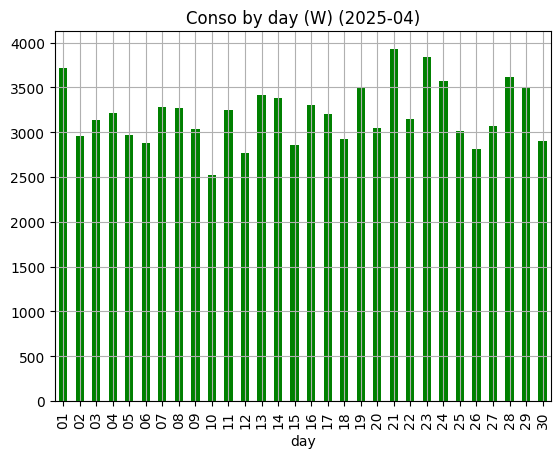

In [585]:
m = '2025-04'
month=conso_grouped_by_month.get_group(m)
conso_grouped_by_month_day = month.groupby(['day'], sort=False)
conso_grouped_by_month_day['kWh'].count().plot(grid=True,kind='bar',color='green',width=.5)
plt.title(f'Conso by day (W) ({m})')

In [586]:
c=conso_grouped_by_month_day['hours'].count()
c.mean()


np.float64(3200.0666666666666)

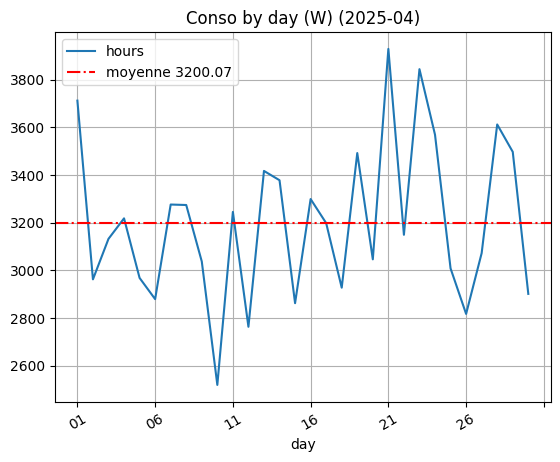

In [587]:
conso_grouped_by_month_day['hours'].count().plot(grid=True)#, kind='bar', color='green', width=.8)
moy = round(c.mean(),2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (W) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);


In [588]:
conso_grouped_by_month_and_day = conso_days[['day','hours','months','kWh']].groupby(['months','day'], sort=False)

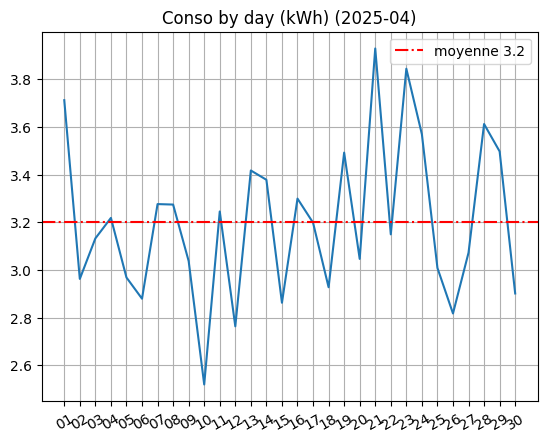

In [589]:
plt.plot(conso_grouped_by_month_day['kWh'].count()/1000)
plt.grid()
moy = round(c.mean()/1000,2)
plt.axhline(y=moy,c='red', ls='-.',label=f'moyenne {moy}')
plt.legend()
plt.title(f'Conso by day (kWh) ({month.iloc[0]['months']})')
plt.xticks(rotation=30);

In [590]:
# Example: Get data for January 2025 at hour '00'
#group = conso_grouped_by_month_and_day.get_group('2025-01')
#group

In [591]:
# group.plot(grid=True, kind='bar', color='green', width=.8)
# plt.title('Conso by hour (W) - 2025-01')
# plt.xticks(rotation=30);


In [592]:
# conso total par mois
conso_grouped_by_month.count()


,day,hours,kWh
months,,,
2024-09,59631,59631,59631
2024-10,73321,73321,73321
2024-11,108177,108177,108177
2024-12,113984,113984,113984
2025-01,113873,113873,113873
2025-02,104281,104281,104281
2025-03,111823,111823,111823
2025-04,96002,96002,96002
2025-05,98608,98608,98608


In [593]:
# example groupby with apply
df2 = pd.DataFrame({'Animal': ['Falcon', 'Falcon',
                              'Parrot', 'Parrot'],
                   'Max Speed': [380., 370., 24., 26.]})
df2.groupby("Animal", group_keys=True)[['Max Speed']].apply(lambda x: x)
      

Max Speed
Animal             
Falcon 0      380.0
       1      370.0
Parrot 2       24.0
       3       26.0

In [594]:
# import pandas as pd
# df = pd.read_csv(r'../csv/only-bh-extreme-events-satellite.csv'
#                   ,index_col=[0,1,2,3,4]
#                   ,header=[0,1,2,3]
#                   ,skipinitialspace=True
#                   #,tupleize_cols=True
#                 ) 

# df.columns = pd.MultiIndex.from_tuples(df.columns)
# df.index.names
# index=df.columns.levels[0]
# index
# df_des = pd.DataFrame(
#                             index=df.columns.levels[0],
#                             columns=['count','mean','std','min','25','50','75','max']
#                          )
# df_des

In [595]:
groupallbyday = conso_days[['days','hours','kWh']].groupby(['days'], sort=False)
groupallbyday[['kWh']].count()  #.apply(lambda x: x))

,kWh
days,
03/09/24,374
04/09/24,4131
05/09/24,3528
06/09/24,3658
07/09/24,3603
...,...
10/07/25,2937
11/07/25,2679
12/07/25,2600


In [596]:
conso_days

,Interval,kWh,sec,Wh,cumul(ms),dates,days,hours,months,day
0,19027,0.19,19.027,189.204814,19027,2024-09-03 21:01:45.435927,03/09/24,21,2024-09,03
1,19214,0.19,19.214,187.363381,38241,2024-09-03 21:02:04.649927,03/09/24,21,2024-09,03
2,19195,0.19,19.195,187.548841,57436,2024-09-03 21:02:23.844927,03/09/24,21,2024-09,03
3,19302,0.19,19.302,186.509170,76738,2024-09-03 21:02:43.146927,03/09/24,21,2024-09,03
4,19385,0.19,19.385,185.710601,96123,2024-09-03 21:03:02.531927,03/09/24,21,2024-09,03
...,...,...,...,...,...,...,...,...,...,...
999995,29757,0.12,29.757,120.979937,27100015484,2025-07-14 12:48:21.892927,14/07/25,12,2025-07,14
999996,30012,0.12,30.012,119.952019,27100045496,2025-07-14 12:48:51.904927,14/07/25,12,2025-07,14
999997,29884,0.12,29.884,120.465801,27100075380,2025-07-14 12:49:21.788927,14/07/25,12,2025-07,14
999998,29953,0.12,29.953,120.188295,27100105333,2025-07-14 12:49:51.741927,14/07/25,12,2025-07,14


In [597]:

# group all by day for all conso_days
groupallbydayhours = conso_days[['days','hours','kWh']].groupby(['days','hours'], sort=False)
# use apply to show the group
groupallbydayhours[['days','hours','kWh']].apply(lambda x: x)


days hours   kWh
days     hours                             
03/09/24 21    0       03/09/24    21  0.19
               1       03/09/24    21  0.19
               2       03/09/24    21  0.19
               3       03/09/24    21  0.19
               4       03/09/24    21  0.19
...                         ...   ...   ...
14/07/25 12    999995  14/07/25    12  0.12
               999996  14/07/25    12  0.12
               999997  14/07/25    12  0.12
               999998  14/07/25    12  0.12
               999999  14/07/25    12  0.12

[1000000 rows x 3 columns]

In [598]:
groupallbyday.indices.keys()

dict_keys(['03/09/24', '04/09/24', '05/09/24', '06/09/24', '07/09/24', '08/09/24', '09/09/24', '10/09/24', '11/09/24', '12/09/24', '13/09/24', '14/09/24', '15/09/24', '16/09/24', '17/09/24', '18/09/24', '19/09/24', '20/09/24', '21/09/24', '22/09/24', '23/09/24', '24/09/24', '25/09/24', '26/09/24', '27/09/24', '28/09/24', '29/09/24', '30/09/24', '01/10/24', '02/10/24', '03/10/24', '04/10/24', '05/10/24', '06/10/24', '07/10/24', '08/10/24', '09/10/24', '10/10/24', '11/10/24', '12/10/24', '13/10/24', '14/10/24', '15/10/24', '16/10/24', '17/10/24', '18/10/24', '19/10/24', '20/10/24', '21/10/24', '22/10/24', '23/10/24', '24/10/24', '25/10/24', '26/10/24', '27/10/24', '28/10/24', '29/10/24', '30/10/24', '31/10/24', '01/11/24', '02/11/24', '03/11/24', '04/11/24', '05/11/24', '06/11/24', '07/11/24', '08/11/24', '09/11/24', '10/11/24', '11/11/24', '12/11/24', '13/11/24', '14/11/24', '15/11/24', '16/11/24', '17/11/24', '18/11/24', '19/11/24', '20/11/24', '21/11/24', '22/11/24', '23/11/24', '24/1

In [599]:
groupallbydayhours.indices.keys()

dict_keys([('03/09/24', '21'), ('03/09/24', '22'), ('03/09/24', '23'), ('04/09/24', '21'), ('04/09/24', '22'), ('04/09/24', '23'), ('04/09/24', '00'), ('04/09/24', '01'), ('04/09/24', '02'), ('04/09/24', '03'), ('04/09/24', '04'), ('04/09/24', '05'), ('04/09/24', '06'), ('04/09/24', '07'), ('04/09/24', '08'), ('04/09/24', '09'), ('04/09/24', '10'), ('04/09/24', '11'), ('04/09/24', '12'), ('04/09/24', '13'), ('04/09/24', '14'), ('04/09/24', '15'), ('04/09/24', '16'), ('04/09/24', '17'), ('04/09/24', '18'), ('04/09/24', '19'), ('04/09/24', '20'), ('05/09/24', '21'), ('05/09/24', '22'), ('05/09/24', '23'), ('05/09/24', '00'), ('05/09/24', '01'), ('05/09/24', '02'), ('05/09/24', '03'), ('05/09/24', '04'), ('05/09/24', '05'), ('05/09/24', '06'), ('05/09/24', '07'), ('05/09/24', '08'), ('05/09/24', '09'), ('05/09/24', '10'), ('05/09/24', '11'), ('05/09/24', '12'), ('05/09/24', '13'), ('05/09/24', '14'), ('05/09/24', '15'), ('05/09/24', '16'), ('05/09/24', '17'), ('05/09/24', '18'), ('05/09/2

In [600]:
grp_by_day = groupallbyday.count()
grp_by_day

,hours,kWh
days,,
03/09/24,374,374
04/09/24,4131,4131
05/09/24,3528,3528
06/09/24,3658,3658
07/09/24,3603,3603
...,...,...
10/07/25,2937,2937
11/07/25,2679,2679
12/07/25,2600,2600


In [601]:
grp_by_day['kWh'].cumsum()

days
03/09/24        374
04/09/24       4505
05/09/24       8033
06/09/24      11691
07/09/24      15294
             ...   
10/07/25     990359
11/07/25     993038
12/07/25     995638
13/07/25     998350
14/07/25    1000000
Name: kWh, Length: 315, dtype: int64

In [602]:
grp_by_dayhours = groupallbydayhours.count()
grp_by_dayhours

kWh
days     hours     
03/09/24 21     124
         22     130
         23     120
04/09/24 00     129
         01     164
...             ...
14/07/25 08     120
         09     127
         10     126
         11     197
         12     113

[7528 rows x 1 columns]

In [603]:
grp_by_dayhours['kWh'].cumsum()

days      hours
03/09/24  21           124
          22           254
          23           374
04/09/24  00           503
          01           667
                    ...   
14/07/25  08        999437
          09        999564
          10        999690
          11        999887
          12       1000000
Name: kWh, Length: 7528, dtype: int64

In [604]:
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(level=0)['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(level=0)['kWh'].diff()
# or
grp_by_dayhours['cumsum'] = grp_by_dayhours.groupby(['days'])['kWh'].cumsum()
grp_by_dayhours['diff'] = grp_by_dayhours.groupby(['days'])['kWh'].diff()
grp_by_dayhours

kWh  cumsum  diff
days     hours                   
03/09/24 21     124     124   NaN
         22     130     254   6.0
         23     120     374 -10.0
04/09/24 00     129     129   NaN
         01     164     293  35.0
...             ...     ...   ...
14/07/25 08     120    1087 -17.0
         09     127    1214   7.0
         10     126    1340  -1.0
         11     197    1537  71.0
         12     113    1650 -84.0

[7528 rows x 3 columns]

In [605]:
today, grp_by_dayhours.loc[today]

('14/07/25',
        kWh  cumsum  diff
 hours                   
 00     113     113   NaN
 01     106     219  -7.0
 02      99     318  -7.0
 03     108     426   9.0
 04     102     528  -6.0
 05     152     680  50.0
 06     150     830  -2.0
 07     137     967 -13.0
 08     120    1087 -17.0
 09     127    1214   7.0
 10     126    1340  -1.0
 11     197    1537  71.0
 12     113    1650 -84.0)

Text(0.5, 1.0, 'Cumul journalier')

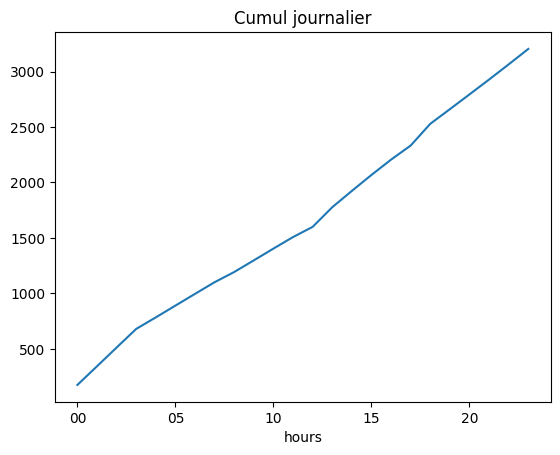

In [606]:
# progression sans surprise
grp_by_dayhours.loc['05/11/24']['cumsum'].plot()
plt.title('Cumul journalier')

Text(0.5, 1.0, 'Variation horaire')

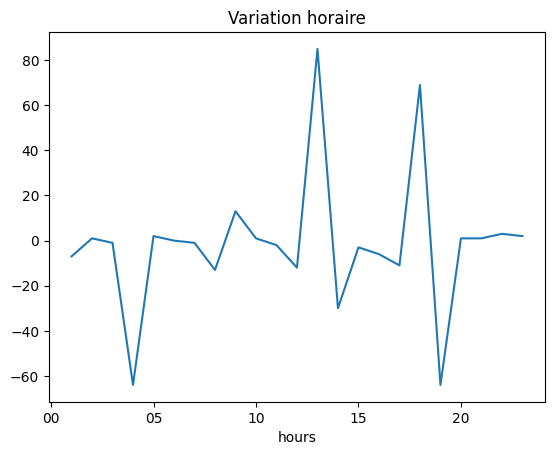

In [607]:
# plus parlant
grp_by_dayhours.loc['05/11/24']['diff'].plot()
plt.title(r'Variation horaire')

In [608]:
# count number of days since 21/08/2023
# https://stackoverflow.com/questions/45972388/count-my-multi-index-length-in-a-dataframe-pandas
n = len(grp_by_dayhours.index.levels[0].unique())
# or
n = len(grp_by_dayhours.index.levels[0])
# or
n = grp_by_dayhours.index.levshape[0]  # levshape -> (371,24)
n

315

In [609]:
df_grp.tail(n)['kWh'].describe()


count    315.000000
mean       3.174603
std        0.752842
min        0.374000
25%        2.790000
50%        3.316000
75%        3.661500
max        4.787000
Name: kWh, dtype: float64

In [610]:
maxday = df_grp.tail(n)['kWh'].idxmax()

In [611]:
n, np.nanmean(df_grp.tail(n))

(315, np.float64(3.1746031746031744))

Text(0.5, 1.0, '315 days')

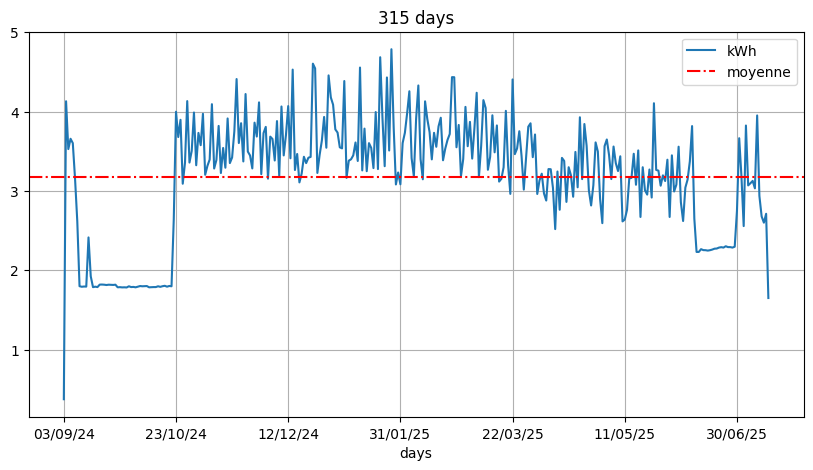

In [612]:
# show conso in span 
span = n
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

Text(0.5, 1.0, '100 days')

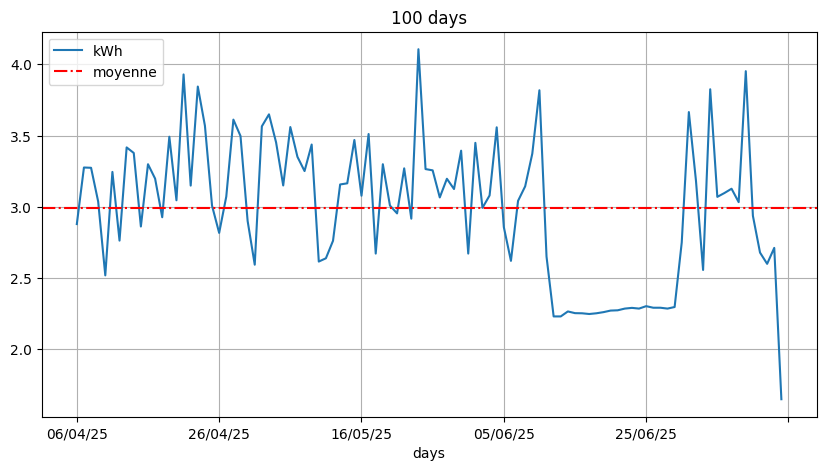

In [613]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.legend()
plt.title(f'{span} days')

In [614]:
np.nanmean(df_grp.tail(span))

np.float64(2.9891799999999993)

In [615]:
df_grp['kWh']

days
03/09/24    0.374
04/09/24    4.131
05/09/24    3.528
06/09/24    3.658
07/09/24    3.603
            ...  
10/07/25    2.937
11/07/25    2.679
12/07/25    2.600
13/07/25    2.712
14/07/25    1.650
Name: kWh, Length: 315, dtype: float64

In [616]:
df_grp.describe()

,kWh
count,315.000000
mean,3.174603
std,0.752842
min,0.374000
25%,2.790000
50%,3.316000
75%,3.661500
max,4.787000


array([[<Axes: title={'center': 'kWh'}>]], dtype=object)

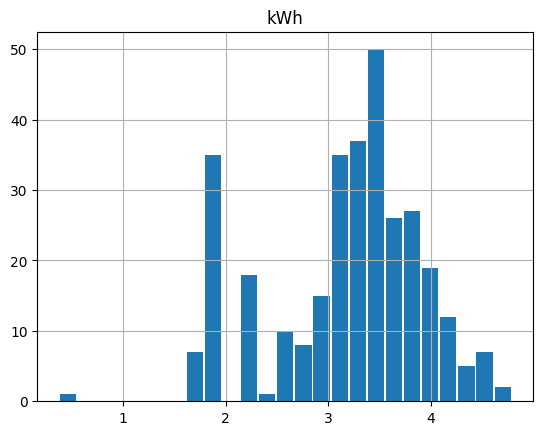

In [617]:
# répartition des consos de 1 à 5 kWh par jour
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
# histtype{'bar', 'barstacked', 'step', 'stepfilled'}, default: 'bar'
df_grp.hist(bins=25, density=False, histtype='bar',rwidth=0.9, align='mid')

In [618]:
df_grp.tail(span)['kWh']

days
06/04/25    2.879
07/04/25    3.276
08/04/25    3.274
09/04/25    3.037
10/04/25    2.519
            ...  
10/07/25    2.937
11/07/25    2.679
12/07/25    2.600
13/07/25    2.712
14/07/25    1.650
Name: kWh, Length: 100, dtype: float64

# Conso par heure

In [619]:
day

'14/07/25'

In [620]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff
hours,,,
00,113,113,NaN
01,106,219,-7.0
02,99,318,-7.0
03,108,426,9.0
04,102,528,-6.0
05,152,680,50.0
06,150,830,-2.0
07,137,967,-13.0
08,120,1087,-17.0


In [621]:
# select a day to plot
day = '02/07/24'
day = today
len(grp_by_dayhours.loc[day])


13

In [622]:
l = range(1,len(grp_by_dayhours.loc[day])+1)
l

range(1, 14)

In [623]:
grp_by_dayhours.loc[day,'days'] = l #ist(1,len(grp_by_day.loc[day])+1)

In [624]:
grp_by_dayhours.loc[day,'days'].values

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.])

In [625]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [626]:
### ????????????????????????
grp_by_dayhours.loc[day,'days'] = grp_by_dayhours.loc[day,'days'].values.astype('int64')

In [627]:
grp_by_dayhours.loc[day].info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, 00 to 12
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   kWh     13 non-null     int64  
 1   cumsum  13 non-null     int64  
 2   diff    12 non-null     float64
 3   days    13 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 520.0+ bytes


In [628]:
grp_by_dayhours.loc[day,'days']

hours
00     1.0
01     2.0
02     3.0
03     4.0
04     5.0
05     6.0
06     7.0
07     8.0
08     9.0
09    10.0
10    11.0
11    12.0
12    13.0
Name: days, dtype: float64

In [629]:
day

'14/07/25'

In [630]:
grp_by_dayhours.loc[day]

,kWh,cumsum,diff,days
hours,,,,
00,113,113,NaN,1.0
01,106,219,-7.0,2.0
02,99,318,-7.0,3.0
03,108,426,9.0,4.0
04,102,528,-6.0,5.0
05,152,680,50.0,6.0
06,150,830,-2.0,7.0
07,137,967,-13.0,8.0
08,120,1087,-17.0,9.0


In [631]:
kwh = grp_by_dayhours.loc[day][['kWh']]/1000
np.sum(kwh)[0]


c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\jeand\AppData\Local\Temp\ipykernel_3340\2885532441.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  np.sum(kwh)[0]


np.float64(1.6500000000000004)

In [632]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
03/09/24 21     124     124   NaN   NaN
         22     130     254   6.0   NaN
         23     120     374 -10.0   NaN
04/09/24 00     129     129   NaN   NaN
         01     164     293  35.0   NaN
...             ...     ...   ...   ...
14/07/25 08     120    1087 -17.0   9.0
         09     127    1214   7.0  10.0
         10     126    1340  -1.0  11.0
         11     197    1537  71.0  12.0
         12     113    1650 -84.0  13.0

[7528 rows x 4 columns]

c:\Users\jeand\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\_core\fromnumeric.py:84: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


Text(0.5, 1.0, '14/07/25: kWh    1.65\ndtype: float64')

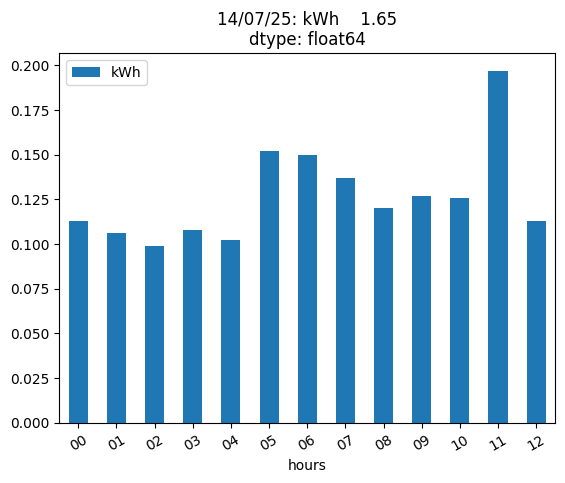

In [633]:
kwh.plot.bar(label='watt')
plt.legend()
plt.xticks(rotation=30)
plt.title(f'{day}: {np.sum(kwh)}')

In [634]:
grp_by_dayhours.loc[day].index

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12'],
      dtype='object', name='hours')

# Conso du jour


In [635]:
grp_by_dayhours.count()

kWh       7528
cumsum    7528
diff      7213
days        13
dtype: int64

'27/01/25'

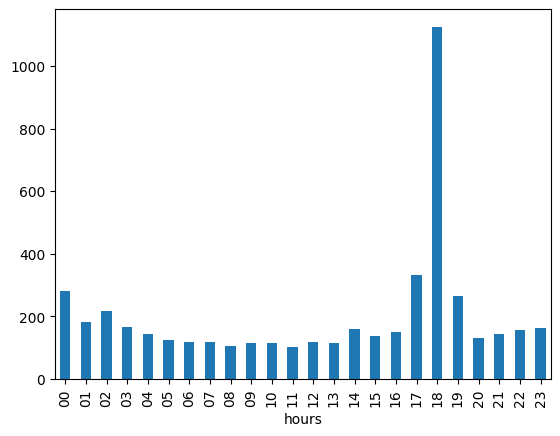

In [636]:
#day = '09/09/24'
day = maxday
#day = today
grp_by_dayhours.loc[day].kWh.plot(kind='bar')
maxday

In [637]:
def conso_by_hour(day):
    global data
    # conso by hour
    #data = groupedbyhour.count().kWh
    data = grp_by_dayhours.loc[day].kWh

    # len(groupedbyhour)
    x = np.arange(1,len(data)+1)
    ymax = max(data)+5
    #groupedbyhour.count().plot(grid=True,xticks=x)
    fig, ax = plt.subplots(figsize=(8, 5), facecolor='darkcyan')

    plt.bar(x,data)
    #plt.grid()
    plt.tight_layout()
    plt.title(f'Conso by hour (W) {day} - Total {sum(data)}')
    plt.xlim(0,len(x)+1)
    #plt.xticks(rotation=30);
    #plt.ylim(0,ymax)

    rects = ax.patches

    # Make some labels.
    labels = [f"{i}" for i in data]
    fontfamily = {'calibri', 'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 3, label, ha="center", va="bottom",
            fontfamily=fontfamily, fontsize=10, fontweight='bold', color='red'
        )


# 100 days

Total= 298.918 , Moyenne= 2.9891799999999993


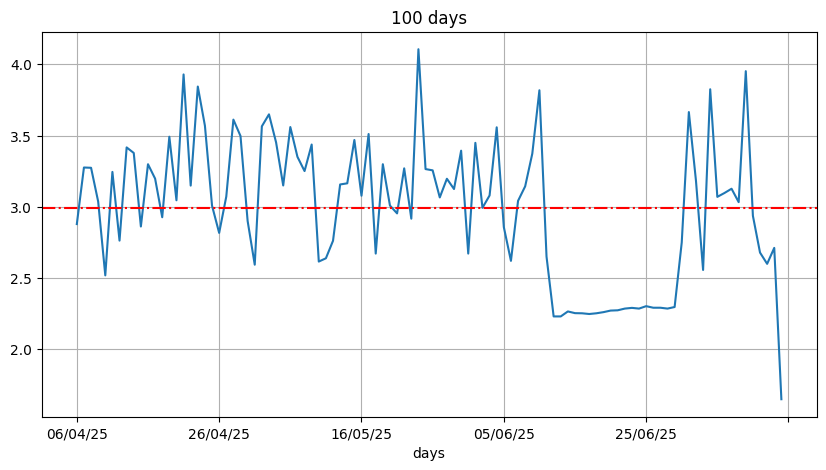

In [638]:
# show conso in span 
span = 100
df_grp.tail(span)['kWh'].plot(figsize=(10, 5), layout='tight', grid=True)
plt.axhline(y=np.nanmean(df_grp.tail(span)),c='red', ls='-.',label='moyenne')
plt.title(f'{span} days')

print('Total=',sum(df_grp.tail(span)['kWh']),', Moyenne=',np.nanmean(df_grp.tail(span)))

In [639]:
from datetime import datetime

# Get the current time
current_time = datetime.now()

# Convert the time to minutes in a day
minutes_in_day = current_time.hour * 60 + current_time.minute
print(f"Current time: {current_time.strftime('%H:%M:%S')}, Minutes in day: {minutes_in_day}")

Current time: 12:51:46, Minutes in day: 771


In [640]:
def convert_to_min_sec(seconds):
    """
    Convert a float value in seconds to minutes and seconds.
    """
    minutes, sec = divmod(seconds, 60)
    return f'{int(minutes)}:{round(sec, 2)}'


In [641]:
#import timeit
#start = timeit.timeit()
#print("hello")
end = time.time()
print(convert_to_min_sec(end - start))

1:32.11


In [642]:
end - start

92.11012530326843

In [643]:
#df = conso_day
show_tranches()

2
2025-07-14 00:00:27.102927	2025-07-14 08:14:24.810927	8h 13m 57s 	1000
2025-07-14 08:14:24.810927	2025-07-14 12:50:20.392927	4h 35m 55s 	650


In [644]:
df_grp.tail(7)['kWh']

days
08/07/25    3.033
09/07/25    3.952
10/07/25    2.937
11/07/25    2.679
12/07/25    2.600
13/07/25    2.712
14/07/25    1.650
Name: kWh, dtype: float64

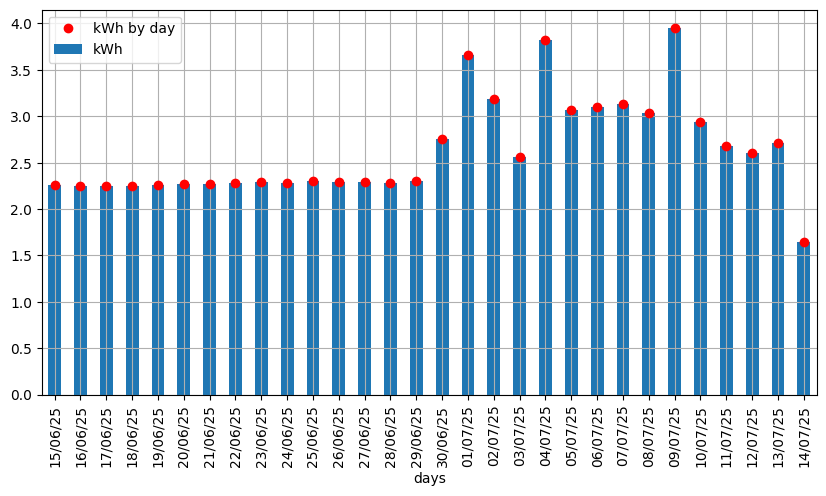

In [645]:
df_grp.tail(30)['kWh'].plot(figsize=(10, 5), kind='bar', layout='tight', grid=True)
plt.plot(df_grp.tail(30)['kWh'], 'ro', label='kWh by day')
plt.legend()

# Today

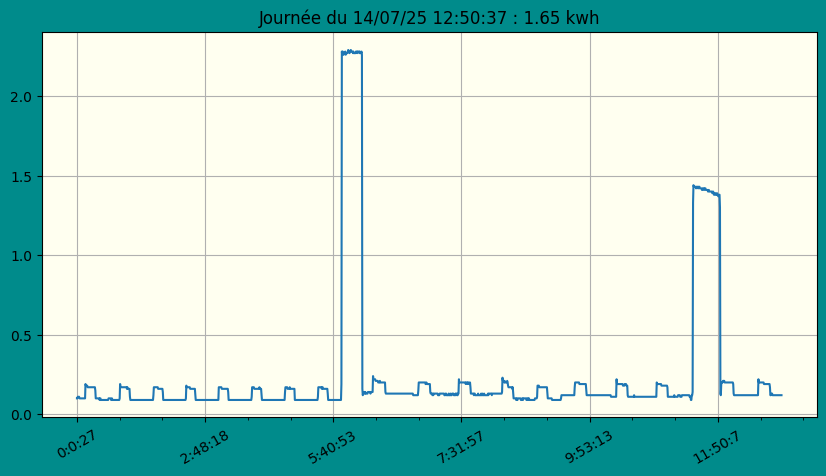

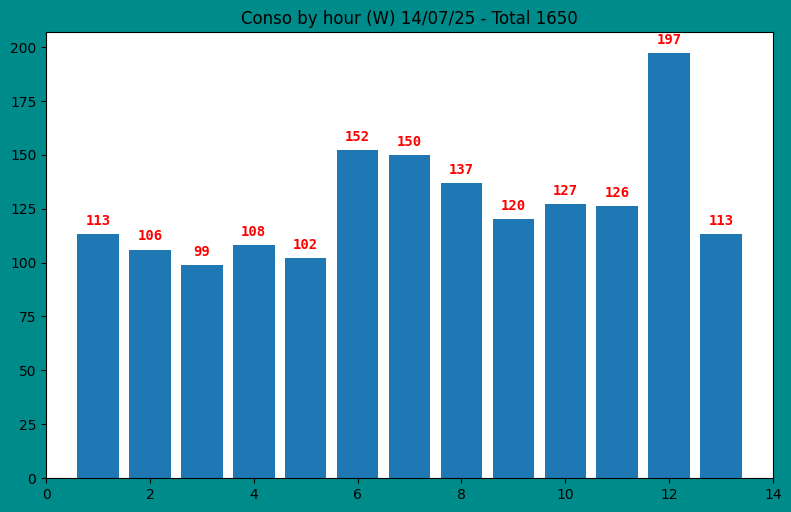

In [646]:
show(today,bgcolor='ivory')
conso_by_hour(today)

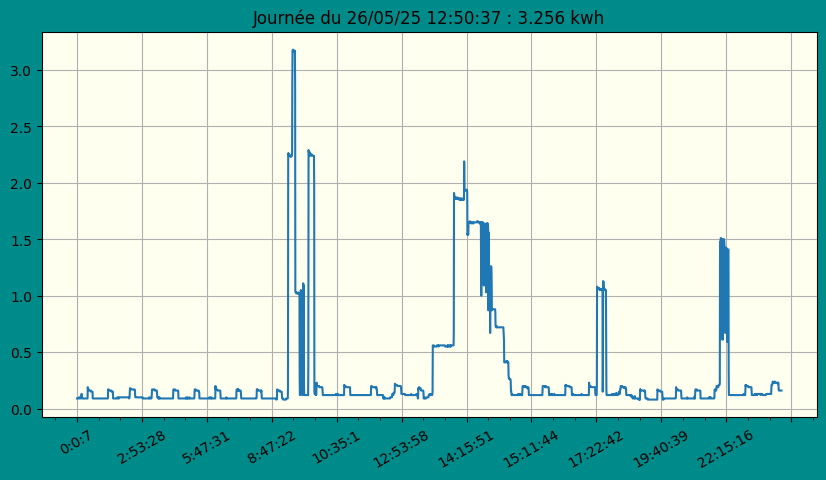

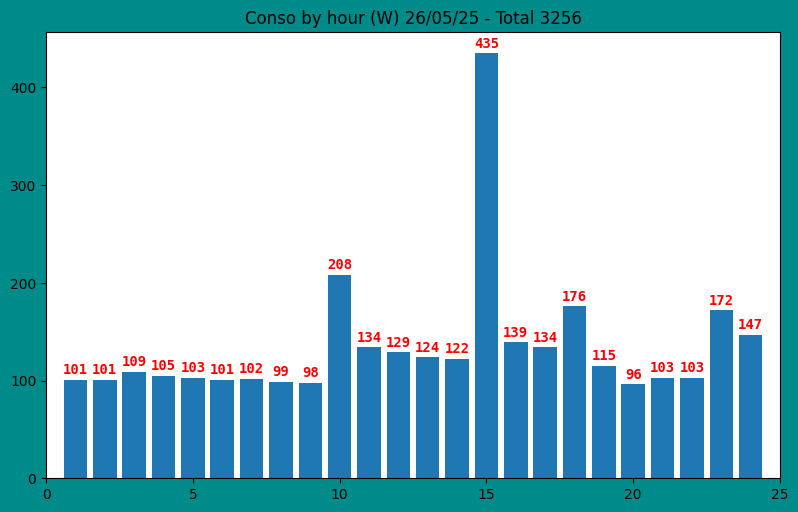

In [647]:
# 21/04/25 cuisine midi et télé le soir 4.115 kWh
day = '26/05/25' 
day, show(day,bgcolor='ivory')
conso_by_hour(day)

27/01/25


(None, 4787)

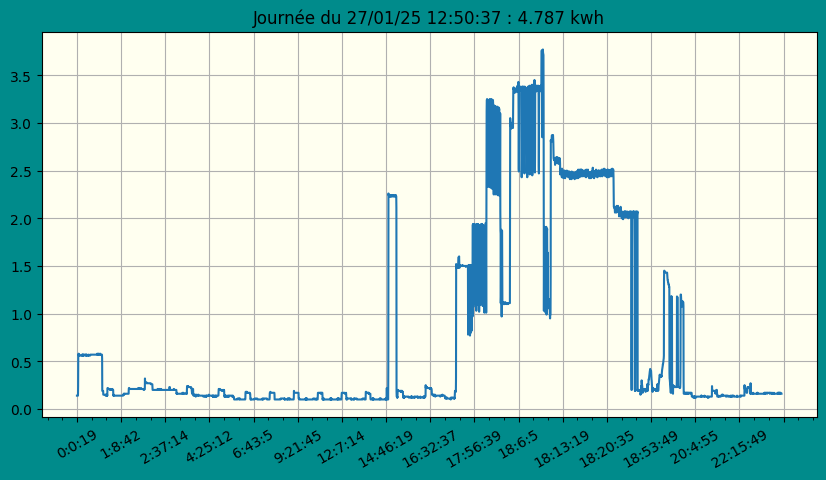

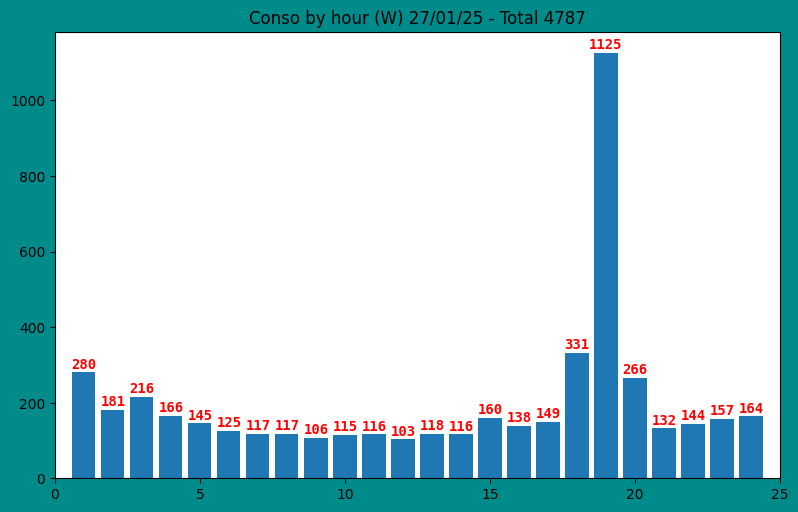

In [648]:
print(maxday)
# retour vietnam 22/10/2024
#day = '22/10/24'
day = maxday
day, show(day,bgcolor='ivory')
conso_by_hour(day),sum(data)

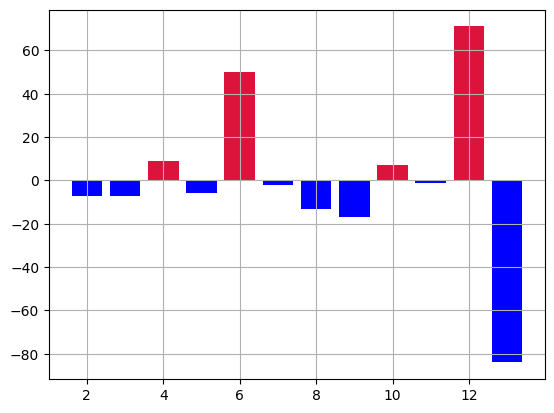

In [649]:
diff = grp_by_dayhours.loc[today]
diff

x = np.arange(1,len(diff)+1)

plt.bar(x,diff['diff'], color=np.where(diff['diff'] > 0, 'crimson', 'blue'))
plt.grid()

<Axes: xlabel='hours'>

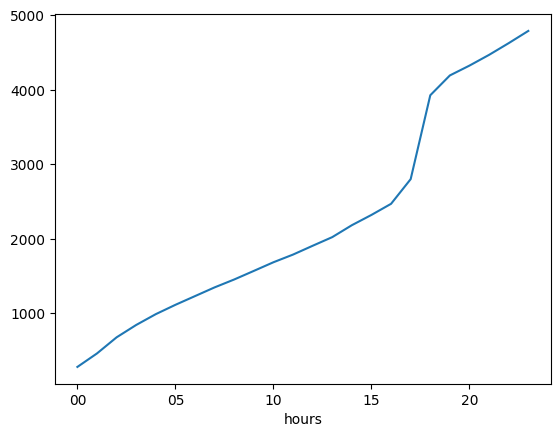

In [650]:
data.cumsum().plot()


<Axes: xlabel='hours'>

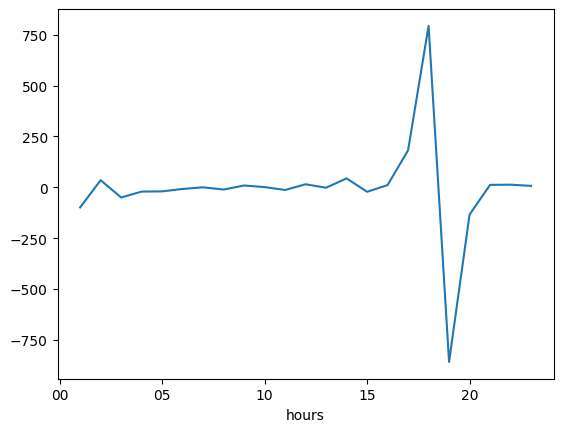

In [651]:
# evolution par heure
data.diff().plot()

In [652]:
data.diff().describe()

count     23.000000
mean      -5.043478
std      255.551717
min     -859.000000
25%      -20.500000
50%        0.000000
75%       12.500000
max      794.000000
Name: kWh, dtype: float64

<Axes: >

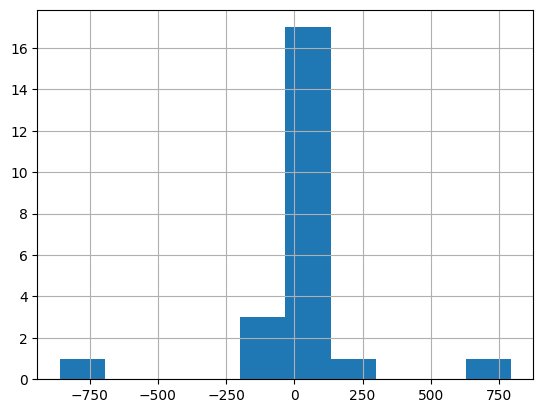

In [653]:
data.diff().hist()

# Test sauvegarde

# list files in current directory


In [654]:
import os
os.listdir(path='.')

['linear combination of atomic orbitals.ipynb',
 'loi_pareto.ipynb',
 'Lotka_Volterra_model.ipynb',
 'bitcoin_api.ipynb',
 'pencil_sketch.ipynb',
 'sample.json',
 'tricks.ipynb',
 'eur_vnd_change_data.ipynb',
 'pandas_course2.ipynb',
 'socket_server.ipynb',
 'tree_minmax.ipynb',
 'amlich_data.py',
 'decimals_pi_plot.ipynb',
 'conso_jour.csv',
 'Mass_Spring_Damper.jpg',
 'mills_primes.ipynb',
 'ligue1_pandas.ipynb',
 'sun_moon_paris_20250603.png',
 'isp_simulation_falcon9.ipynb',
 'primes2million.pkl',
 'socket_client.ipynb',
 'magic_tricks.ipynb',
 'magicdragon.ipynb',
 'rainbow_color.ipynb',
 'snake_game.ipynb',
 'sympy_fun.ipynb',
 'tqdm_benchmark.ipynb',
 'sun_moon_azimuth_paris_2025-06-06.png',
 'ligue1_2020_extended.txt',
 'pd_grp_plot.ipynb',
 'sun_moon_paris_20250605.png',
 'tkinter_scale_color.ipynb',
 'Dewpoint-RH-fr.svg.png',
 'read_xml.ipynb',
 'pi_from_collisions.ipynb',
 'mqtt_temp.ipynb',
 'sudoku_generator.ipynb',
 'onecall_issue.ipynb',
 'poo_chap10.ipynb',
 'de421.bsp'

# list store files csv


In [655]:
res = []
# Iterate directory
for file in os.listdir('.'):
    # check only text files
    if file.endswith('.csv'):
        res.append(file)
        print(file)
#print(res)

conso_jour.csv
table-indicateurs-open-data-france-2023-06-30-17h59.csv
CAC40.csv
Nasdaq.csv
karaoke.csv
saturn_rings.csv
DowJones.csv
planete.csv
conso_par_jour.csv
8days.csv
SMSSpamCollection.csv
df_grp.csv
Ford.csv
Tesla.csv
Nikkei.csv
temp_humidity.csv
titanic.csv
data_temp16122022.csv
week.csv
Toyota.csv
Apple.csv
VNDUSD.csv
demain.csv
saturn_bodies.csv
conso_day_from_20230821.csv
WA_Fn-UseC_-Telco-Customer-Churn.csv
ligue1_2020_27.csv
table-indicateurs-open-data-dep-2023-06-30-17h59.csv
conso_data.csv
EURUSD.csv
df.csv


('27/01/25', None)

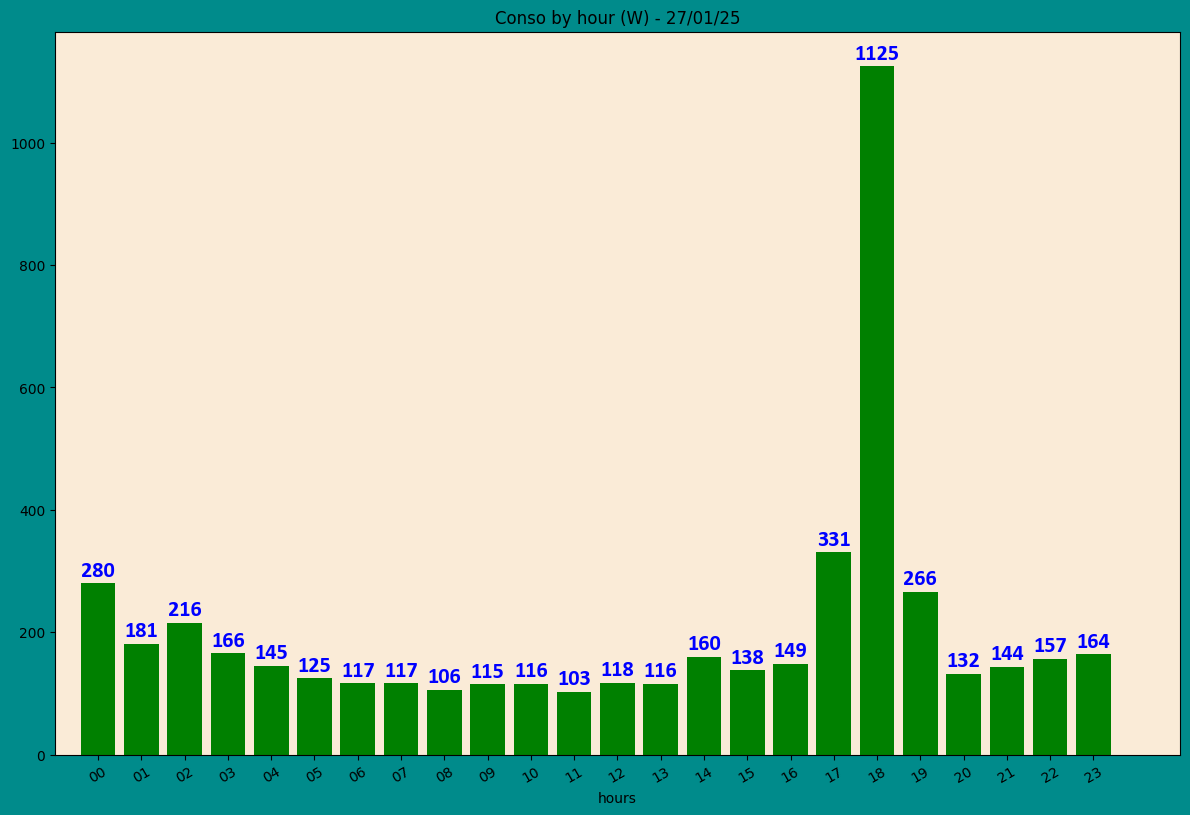

In [656]:
day,conso_byhour(day)

In [657]:
# save to file
import pickle
path = r'../consobyhour.pkl'
with open(path,'wb') as file:
    pickle.dump(data, file)

# plot any day


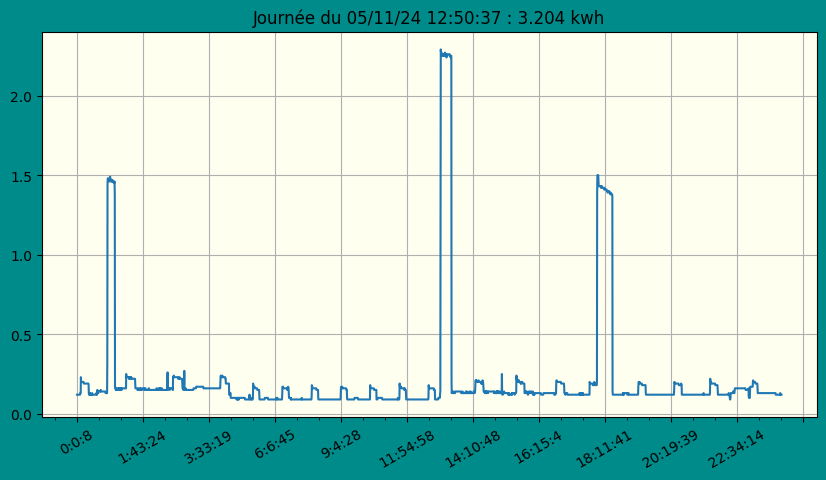

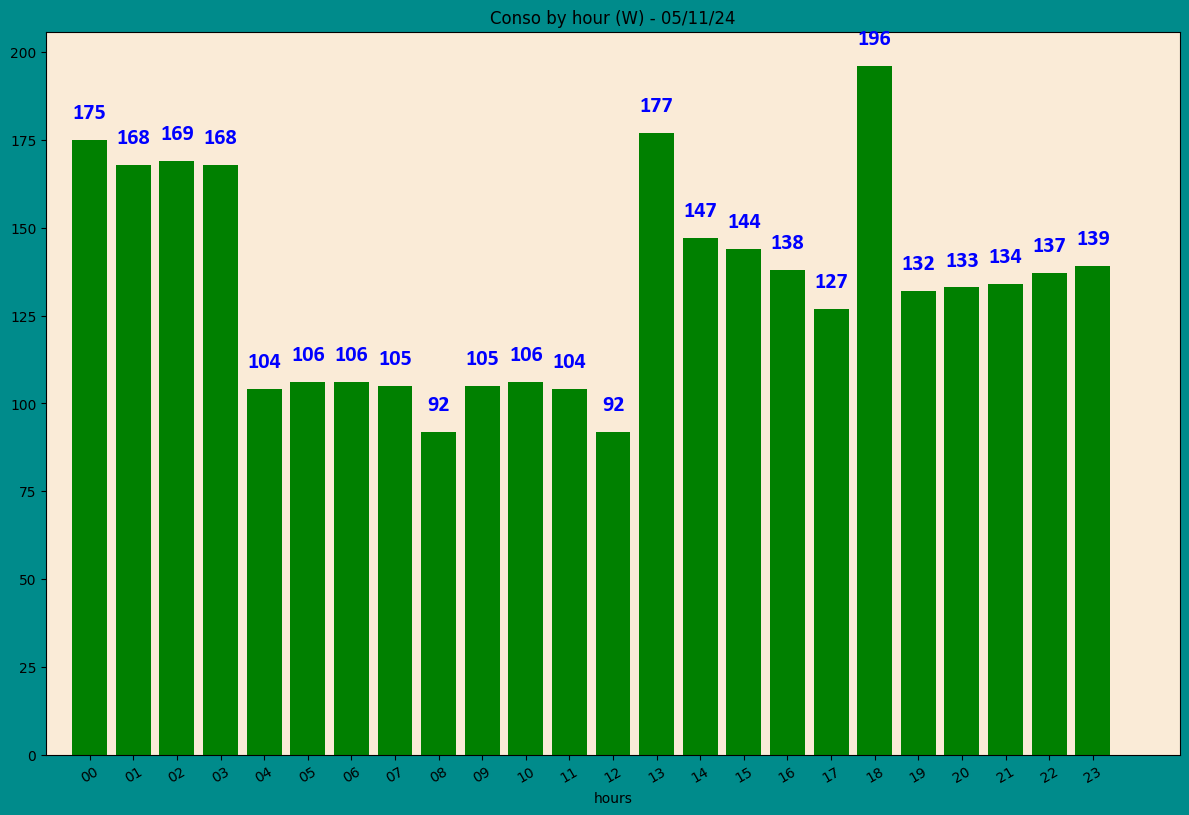

In [658]:
day = '05/11/24'
#day = today
show(day,pltcolor='darkcyan')
conso_byhour(day)

In [659]:
month

,day,hours,months,kWh
685090,01,00,2025-04,0.21
685091,01,00,2025-04,0.21
685092,01,00,2025-04,0.21
685093,01,00,2025-04,0.21
685094,01,00,2025-04,0.21
...,...,...,...,...
781087,30,23,2025-04,0.09
781088,30,23,2025-04,0.09
781089,30,23,2025-04,0.09
781090,30,23,2025-04,0.09


In [660]:
month.describe()


,kWh
count,96002.000000
mean,0.310191
std,0.547369
min,0.080000
25%,0.090000
50%,0.120000
75%,0.180000
max,3.790000


<Axes: >

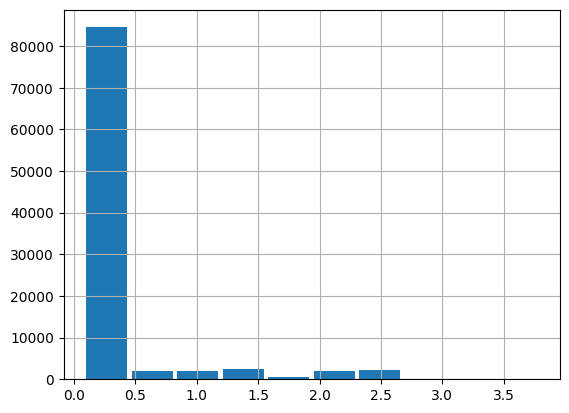

In [661]:
# bins of conso scale by hour
month['kWh'].hist(bins=10, density=False, histtype='bar',rwidth=0.9, align='mid')

<Axes: >

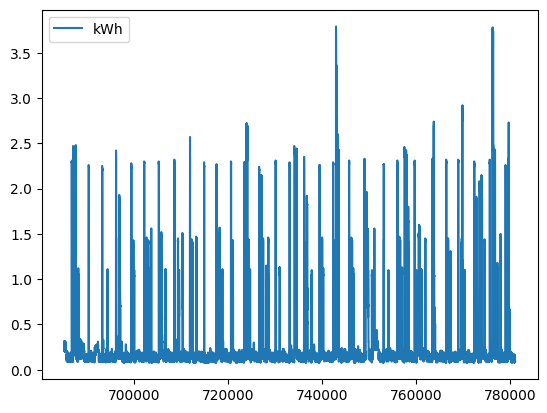

In [662]:
month.plot()

In [663]:
# index with max conso in this month
month.idxmax().kWh

np.int64(742945)

In [664]:
# plot month day max conso (télévision de 11h à 23h)
day_idx = month.idxmax()
#day = '27/10/2024'
day_idx

day       778191
hours     688632
months    685090
kWh       742945
dtype: int64

In [665]:
#show(day,pltcolor='darkcyan')
#conso_byhour(day)

In [666]:
grp_by_dayhours

kWh  cumsum  diff  days
days     hours                         
03/09/24 21     124     124   NaN   NaN
         22     130     254   6.0   NaN
         23     120     374 -10.0   NaN
04/09/24 00     129     129   NaN   NaN
         01     164     293  35.0   NaN
...             ...     ...   ...   ...
14/07/25 08     120    1087 -17.0   9.0
         09     127    1214   7.0  10.0
         10     126    1340  -1.0  11.0
         11     197    1537  71.0  12.0
         12     113    1650 -84.0  13.0

[7528 rows x 4 columns]

In [667]:
month

,day,hours,months,kWh
685090,01,00,2025-04,0.21
685091,01,00,2025-04,0.21
685092,01,00,2025-04,0.21
685093,01,00,2025-04,0.21
685094,01,00,2025-04,0.21
...,...,...,...,...
781087,30,23,2025-04,0.09
781088,30,23,2025-04,0.09
781089,30,23,2025-04,0.09
781090,30,23,2025-04,0.09


In [668]:
month.idxmax()


day       778191
hours     688632
months    685090
kWh       742945
dtype: int64

In [669]:
month.loc[month.idxmax().kWh]


day            19
hours          14
months    2025-04
kWh          3.79
Name: 742945, dtype: object

In [670]:
grp_by_dayhours.loc[['28/02/25']].kWh

days      hours
28/02/25  00       178
          01       176
          02       170
          03       118
          04       114
          05       110
          06       110
          07        99
          08       111
          09       110
          10       109
          11        98
          12       171
          13       144
          14       148
          15       134
          16       201
          17       143
          18       153
          19       197
          20       144
          21       149
          22       140
          23       175
Name: kWh, dtype: int64

In [671]:
max_hour = grp_by_dayhours.loc[['28/02/25']].kWh.idxmax()[1]
max_hour

'16'

<Axes: xlabel='days,hours'>

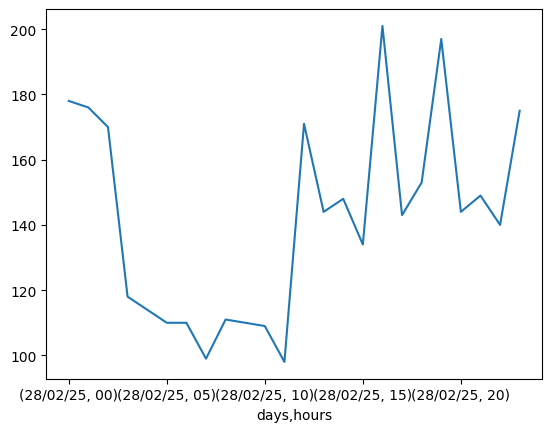

In [672]:
grp_by_dayhours.loc[['28/02/25']].kWh.plot()#.idxmax()

In [673]:
grp_by_dayhours.columns

Index(['kWh', 'cumsum', 'diff', 'days'], dtype='object')

In [674]:
# diff
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['diff'],label=grp_by_dayhours.columns[2])
# plt.legend()

In [675]:
# cumsum
# plt.plot(grp_by_dayhours.loc[month.idxmax()]['cumsum'],label=grp_by_dayhours.columns[1])
# plt.legend()

In [676]:
# 41 s
# file to big to git sync

# create .gitignore
filename=r'../conso_data.csv'
#conso_data.to_csv(filename)
#43.6s size 140128 kB